### Elastic net minimization over inconsistent linear system
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We want to solve:

\begin{align}
\min_x \quad & g(x):= \n{x}_1 + \frac \c 2 \n{x}^2\\
\text{s.t. } \quad & x\in \min_y \n{Ay-b}^2
\end{align}


We will apply two methods: PDA-1 to the problem $\min_x g(x)$ s.t. $Ax=b$ and PDA-2 to the problem $\min_x g(x)$ s.t. $A^*Ax = A^*b$. As it is shown in the paper, despite the system Ax=b is inconsistent, PDA-1 still converges to a solution of the original problem.

In [10]:
from pd_algorithms import *
from opt_operators import *
from output import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Choose one of the following problem instances or generate a new one. In the comments there are the best parameters for those problems (for now this is not important)

In [3]:
m, n, r = 70, 100, 50
# i, i2 = 3, 7

In [15]:
m, n, r =  100, 200, 50
# i, i2 = 4, 9

In [22]:
m, n, r = 100, 500, 50
# i, i2 = 5, 10

In [32]:
m, n, r = 300, 500, 50
# i, i2 = 6, 11

In [4]:
# fix the random generator
gen = 100
np.random.seed(gen)


# sparsity of the solution
l_spr = 20

# level of noise
noise = 0.1

# A is m x n matrix with rank A = r
Q1 = np.random.normal(0,1,(m, r))
Q2 = np.random.normal(0,1,(r, n))
A = Q1.dot(Q2)

w = np.random.uniform(-1, 1, n)                   
w[l_spr:] = 0                                  
w = np.random.permutation(w)

nu = np.random.normal(0, noise, m)  

b = A.dot(w) + nu

B = A.T.dot(A)
c = A.T.dot(b)

gamma = 0.1
g = lambda x: LA.norm(x,1) + gamma*0.5*x.dot(x)
prox_g = lambda x, rho: prox_norm_elastic_net(x, rho, gamma*rho)

# conjugate function for PDA-1
f_conj = lambda y: b.dot(y)
prox_f_conj = lambda y, rho: y - rho*b

# conjugate function for PDA-2
f_conj2 = lambda y: c.dot(y)
prox_f_conj2 = lambda y, rho: y - rho*c

# to check the feasibility gap
h = lambda x: LA.norm(A.dot(x)-b)
h2 = lambda x: LA.norm(B.dot(x)-c)

# some energy functional
J = lambda x, y: 0

In [5]:
L = np.max(LA.eigh(B)[0])

# starting point
x0 = np.zeros(n)

# for PDA-1
alpha = 1 / np.sqrt(L)
y0 = np.zeros(m)

# for PDA-2
alpha2 = 1 / L
y02 = np.zeros(n)

Find the best parameters $\t$ and $\s$ for the PDA-1. For simplicity, we check only the feasibility gap.

In [6]:
N = 10000
i_low = -3
i_up = 15
i_range = range(i_low,i_up)
best_ratio = list(range(i_up-i_low))

for n_arr, i in enumerate(i_range):
    best_ratio[n_arr] =  pd(J, prox_g, prox_f_conj, A, x0, y0, 1/2**i * alpha, 2**i * alpha, numb_iter=N)
    p = best_ratio[n_arr][1]
    print((i, h2(p)))

----- Primal-dual method -----
Time execution: 0.3641591769999999
(-3, 0.023567525680686978)
----- Primal-dual method -----
Time execution: 0.3658040119999999
(-2, 0.0075168094994573862)
----- Primal-dual method -----
Time execution: 0.3764856280000002
(-1, 0.0043511511046507656)
----- Primal-dual method -----
Time execution: 0.4769717490000005
(0, 0.0031437227028251412)
----- Primal-dual method -----
Time execution: 0.38596250700000034
(1, 0.00071154775751320536)
----- Primal-dual method -----
Time execution: 0.38000666800000005
(2, 4.5432973587758002e-05)
----- Primal-dual method -----
Time execution: 0.37141965700000057
(3, 9.1911689928037025e-06)
----- Primal-dual method -----
Time execution: 0.3698645489999999
(4, 0.028065626060391938)
----- Primal-dual method -----
Time execution: 0.3688158020000003
(5, 0.54809946240840235)
----- Primal-dual method -----
Time execution: 0.4391326410000005
(6, 0.8768716904545143)
----- Primal-dual method -----
Time execution: 0.3856852110000002
(7

Choose the best index $i$ and set $\s = \frac{1}{2^i \sqrt{L}}$, $\t = \frac{2^i}{\sqrt L}$ and find the solution $x_{sol}$ after $N = 100000$ iterations:

In [7]:
N = 100000
i = 3
sigma = 1/2**i * alpha
tau = 2**i * alpha

ans1 = pd(J, prox_g, prox_f_conj, A, x0, y0, sigma, tau, numb_iter=N)
x_sol = ans1[1]
print('the feasibility gap is', h2(x_sol))

----- Primal-dual method -----
Time execution: 3.5838276029999996
the feasibility gap is 3.1176775692e-10


Similarly, find the best parameters $\s$ and $\t$ for the PDA-2. If all instances do not reach
a small enough feasibility gap, increase the number of iterations $N$ and run the same cycle.

In [58]:
N = 300000
i_low = 4
i_up = 9
i_range = range(i_low,i_up)
best_ratio = list(range(i_up-i_low))

for n_arr, i in enumerate(i_range):
    best_ratio[n_arr] =  pd(J, prox_g, prox_f_conj2, B, x0, y02, 1/2**i * alpha2, 2**i * alpha2, numb_iter=N)
    p = best_ratio[n_arr][1]
    print((i, h2(p)))

----- Primal-dual method -----
Time execution: 100.45295905900002
(4, 6.1301983086925927e-05)
----- Primal-dual method -----
Time execution: 90.90076564600031
(5, 2.9434739060461306e-07)
----- Primal-dual method -----
Time execution: 90.78636524399963
(6, 3.5310597834357717e-11)
----- Primal-dual method -----
Time execution: 88.1705659610002
(7, 7.5003204672209754e-12)
----- Primal-dual method -----
Time execution: 91.57855596300033
(8, 0.014852647951807806)


Set $i_2$ as the index with the best performance of PDA-2 and $\s_2$, $\t_2$ as the respective stepsizes:

In [8]:
i2 = 7

sigma2 = 1/2**i2 * alpha2
tau2 = 2**i2 * alpha2

In [9]:
# choose for which function we want to compare the convergence of PDA-1 and PDA-2. 
# Below we use J(x) = ||x^k - x^*|| but we can also compare feasibility gap
J = lambda x, y: LA.norm(x-x_sol)
#J = lambda x, y: h2(x)

# number of iterations
N = 15000

ans1 = pd(J, prox_g, prox_f_conj, A, x0, y0, sigma, tau, numb_iter=N)
ans2 = pd(J, prox_g, prox_f_conj2, B, x0, y02, sigma2, tau2, numb_iter=N)

----- Primal-dual method -----
Time execution: 0.7755550549999999
----- Primal-dual method -----
Time execution: 6.325778797


Make plots

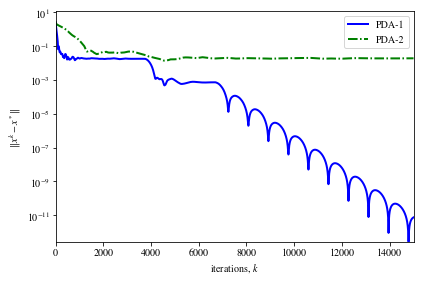

In [12]:
plt.plot(ans1[0], 'b', label='PDA-1')
plt.plot(ans2[0], '-.g', label = 'PDA-2')
plt.yscale('log')
plt.legend()
plt.xlabel('iterations, $k$')
plt.ylabel('$\Vert x^k-x^*\Vert$')
plt.minorticks_off()
plt.tight_layout()
plt.xlim(0, N)
plt.ylim(0)
plt.savefig('figures/elastic-1.pdf')
plt.show()
plt.clf()